# MNIST Multidígito - Baseado na SSD

## Importando os módulos

In [1]:
#!pip install matplotlib torch torchvision shapely[vectorized]

In [2]:
#!wget -q https://raw.githubusercontent.com/fabiocapsouza/ia376f/master/lib/pytorch_trainer_v2_mod.py -Plib/

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import os
import math
import warnings
from collections import OrderedDict

import cv2
import numpy as np
from shapely import geometry

import matplotlib.pyplot as plt
from matplotlib import patches, patheffects
import matplotlib.cm as cmx
import matplotlib.colors as mcolors

import torch
import torch.nn as nn
from torch.utils import data
from torch.optim import lr_scheduler
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

# our library
from lib import pytorch_trainer_v2_mod as ptt

In [3]:
torch.backends.cudnn.benchmark = False

In [4]:
# verifica se a GPU esta disponivel
use_gpu = torch.cuda.is_available()
print("Usando GPU:", use_gpu)
print('CPU Cores:', os.cpu_count())
print('Versão OpenCV:', cv2.__version__)

Usando GPU: True
CPU Cores: 4
Versão OpenCV: 3.4.2


## Setup

In [5]:
def to_device(T, device):
    if isinstance(T, (list, tuple)):
        return [to_device(t, device) for t in T]
    elif isinstance(T, dict):
        return {k: to_device(t) for k, t in T.items()}
    return T.to(device)

Funções do fast.ai para plotar imagens e boxes

In [6]:
def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

In [7]:
def show_img(im, figsize=None, ax=None, cmap='gray'):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, cmap=cmap)
    ax.set_xticks(np.linspace(0, 224, 8))
    ax.set_yticks(np.linspace(0, 224, 8))
    ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    """b: box (x0, y0, w, h)"""
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

## Carregando MNIST dataset

In [8]:
!mkdir data/MNIST

mkdir: cannot create directory ‘data/MNIST’: File exists


In [9]:
dataset_dir = 'data/MNIST/'

# Transformara os dados em tensores no intervalo [0.0, 1.0] (Os dados serão normalizados)
data_transform = transforms.ToTensor()
# data_transform = None

# carrega o conjunto de treinamento e de teste
datasets_mnist = dict(train=MNIST(dataset_dir, train=True,  transform=data_transform, download=True),
                val  =MNIST(dataset_dir, train=False, transform=data_transform, download=True))

print('Amostras para treinamento:', len(datasets_mnist['train']))
print('Amostras para validação:', len(datasets_mnist['val']))
print(type(datasets_mnist['train'].train_data))
print(datasets_mnist['train'].train_data.size())
print(datasets_mnist['train'].train_data.min(), datasets_mnist['train'].train_data.max())

Amostras para treinamento: 60000
Amostras para validação: 10000
<class 'torch.Tensor'>
torch.Size([60000, 28, 28])
tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)


# Definição do dataset com múltiplos dígitos

## Testes iniciais

In [10]:
np.random.choice(60000, 15, replace=False)

array([59844, 51044,  8889, 15585, 36235, 57080, 57938, 34521, 29986,
       11704, 55382, 56559, 56209, 19188, 43350])

In [11]:
def make_geometry_box(h, w, H, W, padding=0):
    """
    h e w: altura e largura da caixa
    H e W: altura e largura da imagem
    """
    x = np.random.randint(0, W-1-w)
    y = np.random.randint(0, H-1-h)
    geom_box = geometry.box(x, y, x+w, y+h)
    return x, y, geom_box


def make_digit_sequence(dataset, digits_ixs, resizing_factor, spacing):
    """Takes a sequence of digits_ixs and concatenate the images from dataset laterally."""
    
    H = int(math.ceil(28 * resizing_factor))
    spacing = int(round(spacing * resizing_factor))
    W = H + (H - spacing) * (len(digits_ixs) - 1)
    seq_img = np.zeros((H, W), dtype=np.int)
    
    seq_label = []
    
    x = 0
    for j, ix in enumerate(digits_ixs):
        img, lab = dataset[ix]
        img, lab = img.numpy(), lab.numpy()
        img = img.reshape(28, 28)
        seq_label.append(str(int(lab)))
        
        img = cv2.resize(img, (H, H), #fx=resizing_factor, fy=resizing_factor,
                         interpolation=cv2.INTER_AREA if resizing_factor < 1 else cv2.INTER_LINEAR)
        img = (img * 255).clip(0, 255).astype(np.uint8)
        if j > 0:
            seq_img[:, x-spacing:x-spacing+H] += img
        else:
            seq_img[:, x:x+H] += img
        x += H-spacing
        
    seq_img = np.clip(seq_img, 0, 255).astype(np.uint8)
        
    return seq_img, ''.join(seq_label)
        

# Função para criar uma imagem de teste, colocando várias amostras
def make_sample(dataset, image_size, min_seq=6, max_seq=6, min_digits=1, max_digits=6, seed=None):
    """Creates an image with many digits from MNIST, without overlap.
    Parameters:
    -----------
    dataset: an instance of MNIST dataset.
    image_size: the output image size. Should be an int of tuple of ints.
    min_seq (int): minimum number of digit sequences in image.
    max_seq (int): maximum number of digit sequences in image.
    min_digits (int): minimum number of digits in a sequence.
    max_digits (int): maximum number of digits in a sequence.
    seed (int, optional): constrols the random seed used to generate the images.
        Used for debugging."""
    if isinstance(image_size, int):
        M = (image_size, image_size)
    elif isinstance(image_size, (tuple, list)):
        M = image_size
    else:
        raise TypeError("`image_size` should be an int of tuple of ints.")
    H, W = M
    
    if seed is not None:
        np.random.seed(seed)
    
    Ns = np.random.randint(min_seq, max_seq)    # Number of digit sequences
    
    # Empty image and outputs
    boxes = []
    boxes_geo = []
    image = np.zeros(M, np.uint8)
    
    spacing = 3   # pixels that will be removed between consecutive digits in a sequence
    
    for seq_ix in range(Ns):
        
        # Samples a number of digits
        N_digits = np.random.randint(min_digits, max_digits)
        
        # Samples a resizing factor and a random position for the digit
        max_factor = min((0.95*H / N_digits) / 28, 2)
        resizing_factor = np.random.uniform(1, max_factor)
        
        hs = int(math.ceil(img.shape[0] * resizing_factor))
        res_spacing = int(round(spacing * resizing_factor))
        ws = hs + (hs - res_spacing) * (N_digits - 1)
        x, y, seq_box = make_geometry_box(hs, ws, H, W)

        if boxes:
            retries = 0
            skip = False
            # If the geometry box intersects with a previous box, resample
            while any(seq_box.intersects(box) for box in boxes_geo):
                if retries > 10:
                    skip = True
                    break
                x, y, seq_box = make_geometry_box(hs, ws, H, W)
                retries += 1
            if skip:
                continue
        
        boxes_geo.append(seq_box)
        digits_ixs = np.random.choice(len(dataset), N_digits, replace=False)
        seq_img, seq_label = make_digit_sequence(dataset, digits_ixs, resizing_factor, spacing)
        
        assert (hs, ws) == seq_img.shape
        
        boxes.append({
            'coords': np.array([x, y, x+ws, y+hs], dtype=np.float) / H,  # This assumes square image size
            'label': seq_label,
        })
        image[y:y+hs, x:x+ws] = seq_img
        
    return image, boxes

Text(0.5,1,'934313')

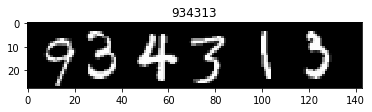

In [12]:
img, lab = make_digit_sequence(datasets_mnist['train'], np.random.randint(0, 60000, 6), 1, 5)
plt.imshow(img, cmap='gray')
plt.title(lab)

In [13]:
sample = make_sample(datasets_mnist['train'], (224, 224), min_seq=3, max_seq=6, seed=None)
sample

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 [{'coords': array([0.05803571, 0.23214286, 0.74553571, 0.38392857]),
   'label': '66195'},
  {'coords': array([0.02232143, 0.58035714, 0.83035714, 0.79910714]),
   'label': '2411'},
  {'coords': array([0.25892857, 0.03125   , 0.97767857, 0.22767857]),
   'label': '2722'}])

In [14]:
def plot_sample(sample):

    img, boxes = sample
    H, W = img.shape
    img = np.dstack((img, img, img))
    
    ax = show_img(img, figsize=(5, 5))
    
    for box in boxes:
        coords = box['coords'].copy()
        text = box['label']
        
        # Convert xyxy to xyhw
        coords[0::2] *= W
        coords[1::2] *= H
        coords[2:] -= coords[:2]
        draw_rect(ax, coords)

    ax.set_xticks(np.arange(0, W, 16), minor=False)
    ax.set_yticks(np.arange(0, H, 16), minor=False)
    ax.grid(True, which='major', linestyle='-')
    ax.grid(True, which='minor', linestyle=':')

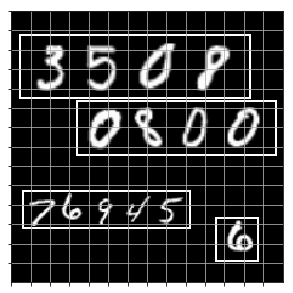

In [15]:
plot_sample(make_sample(datasets_mnist['train'], (224, 224), min_seq=3, max_seq=6, seed=42))

In [16]:
class MultiSequenceDataset(torch.utils.data.Dataset):
    
    def __init__(self, dataset, image_size=(224, 224), transform=None, length=None,
                 random=False, min_seq=3, max_seq=6):
        self.dataset = dataset
        self.image_size = image_size
        self.length = length or len(dataset)
        self.random = random
        self.min_seq = min_seq
        self.max_seq = max_seq
        
        self.transform = transform
        
    def set_length(self, length):
        """Sets the length of the dataset. Useful to limit the dataset
        to a small number of samples."""
        self.length = length
        
    def __len__(self):
        return self.length
        
    def __getitem__(self, ix):
        seed = ix if not self.random else None
        img, boxes = make_sample(self.dataset, self.image_size, 
                                 min_seq=self.min_seq, max_seq=self.max_seq,
                                 seed=seed)
        
        img = img[..., np.newaxis]
        
        if self.transform:
            img = self.transform(img)
        return img, boxes

Visualizando shapes, dtypes, valores mínimo e máximo

In [17]:
ds = {
    'train': MultiSequenceDataset(datasets_mnist['train'], image_size=(224, 224), length=128, random=False),
    'val': MultiSequenceDataset(datasets_mnist['val'], image_size=(224, 224), length=128, random=False),
}

In [18]:
x, y = ds['train'][1]

print('x:', x.shape, x.dtype, x.min(), x.max())
print(y)

x: (224, 224, 1) uint8 0 255
[{'coords': array([0.04017857, 0.59375   , 0.8125    , 0.80357143]), 'label': '7922'}, {'coords': array([0.25892857, 0.8125    , 0.91964286, 0.99107143]), 'label': '6522'}, {'coords': array([0.625     , 0.18303571, 0.91964286, 0.33928571]), 'label': '92'}, {'coords': array([0.1875    , 0.34375   , 0.97767857, 0.55803571]), 'label': '8894'}]


## Definição do modelo

### Construindo as âncoras:

- Anchors 37x37 para camada de downsample 16 (span entre [18.5, 55.5] após resize) com 3 razões de aspecto
- Anchors 46x46 para camada de  downsample 32 (span entre [23.0, 69.0] após resize) com 3 razões de aspecto

In [19]:
def make_anchors(anc_grid, anc_size, k=1):
    """
    Constrói anchors quadradas de acordo com os tamanhos fornecidos para
    o grid e para as anchors.
    
    anc_grid (int): dimension (h|w) of the feature map.
    anc_size (float or tuple of floats): size (WH) of the anchors, relative to the image size.
    Retorna anchors (Cx, Cy, H, W) com shape (k*anc_grid*anc_grid, 4).
    """
    if isinstance(anc_size, float):
        anc_size = (anc_size, anc_size)
    
    anc_offset = 1/(anc_grid*2)
    anc_x = np.repeat(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)
    anc_y = np.tile(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)

    anc_ctrs = np.tile(np.stack([anc_x,anc_y], axis=1), (k,1))
    anc_sizes = np.array([anc_size for i in range(anc_grid*anc_grid)])
    anchors = torch.tensor(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()
    return anchors

In [20]:
# Anchor para a camada com downsample 16 => grid 14x14
# Exemplo: Razão de aspecto w:h = 3:1
make_anchors(14, (37*3/224, 37/224))

tensor([[0.0357, 0.0357, 0.4955, 0.1652],
        [0.0357, 0.1071, 0.4955, 0.1652],
        [0.0357, 0.1786, 0.4955, 0.1652],
        [0.0357, 0.2500, 0.4955, 0.1652],
        [0.0357, 0.3214, 0.4955, 0.1652],
        [0.0357, 0.3929, 0.4955, 0.1652],
        [0.0357, 0.4643, 0.4955, 0.1652],
        [0.0357, 0.5357, 0.4955, 0.1652],
        [0.0357, 0.6071, 0.4955, 0.1652],
        [0.0357, 0.6786, 0.4955, 0.1652],
        [0.0357, 0.7500, 0.4955, 0.1652],
        [0.0357, 0.8214, 0.4955, 0.1652],
        [0.0357, 0.8929, 0.4955, 0.1652],
        [0.0357, 0.9643, 0.4955, 0.1652],
        [0.1071, 0.0357, 0.4955, 0.1652],
        [0.1071, 0.1071, 0.4955, 0.1652],
        [0.1071, 0.1786, 0.4955, 0.1652],
        [0.1071, 0.2500, 0.4955, 0.1652],
        [0.1071, 0.3214, 0.4955, 0.1652],
        [0.1071, 0.3929, 0.4955, 0.1652],
        [0.1071, 0.4643, 0.4955, 0.1652],
        [0.1071, 0.5357, 0.4955, 0.1652],
        [0.1071, 0.6071, 0.4955, 0.1652],
        [0.1071, 0.6786, 0.4955, 0

In [21]:
# Anchors com downsample=32 => grid_size = 7
# Exemplo: anchor quadrada 46x46
make_anchors(7, 46/224)

tensor([[0.0714, 0.0714, 0.2054, 0.2054],
        [0.0714, 0.2143, 0.2054, 0.2054],
        [0.0714, 0.3571, 0.2054, 0.2054],
        [0.0714, 0.5000, 0.2054, 0.2054],
        [0.0714, 0.6429, 0.2054, 0.2054],
        [0.0714, 0.7857, 0.2054, 0.2054],
        [0.0714, 0.9286, 0.2054, 0.2054],
        [0.2143, 0.0714, 0.2054, 0.2054],
        [0.2143, 0.2143, 0.2054, 0.2054],
        [0.2143, 0.3571, 0.2054, 0.2054],
        [0.2143, 0.5000, 0.2054, 0.2054],
        [0.2143, 0.6429, 0.2054, 0.2054],
        [0.2143, 0.7857, 0.2054, 0.2054],
        [0.2143, 0.9286, 0.2054, 0.2054],
        [0.3571, 0.0714, 0.2054, 0.2054],
        [0.3571, 0.2143, 0.2054, 0.2054],
        [0.3571, 0.3571, 0.2054, 0.2054],
        [0.3571, 0.5000, 0.2054, 0.2054],
        [0.3571, 0.6429, 0.2054, 0.2054],
        [0.3571, 0.7857, 0.2054, 0.2054],
        [0.3571, 0.9286, 0.2054, 0.2054],
        [0.5000, 0.0714, 0.2054, 0.2054],
        [0.5000, 0.2143, 0.2054, 0.2054],
        [0.5000, 0.3571, 0.2054, 0

In [22]:
# Conversão entre representações de bboxes
def hw2corners(centers, hw):
    """ bbox centers+hw to top-left+bottom-right"""
    return torch.cat([centers - hw/2, centers + hw/2], dim=1)

def corners2xyhw(tleft, bright):
    """ bbox top-left+bottom-right to top-left+hw."""
    return torch.cat([tleft, bright-tleft], dim=1)

def hw2xy(box):
    """bbox top-left+hw to top-left+bottom-right"""
    return torch.cat([box[:,:2], box[:,:2] + box[:,2:]], dim=1)

In [23]:
# Exemplo de anchors (x1, y1, x2, y2)
anc = make_anchors(5, 1/5)
hw2corners(anc[:, :2], anc[:, 2:])

tensor([[0.0000, 0.0000, 0.2000, 0.2000],
        [0.0000, 0.2000, 0.2000, 0.4000],
        [0.0000, 0.4000, 0.2000, 0.6000],
        [0.0000, 0.6000, 0.2000, 0.8000],
        [0.0000, 0.8000, 0.2000, 1.0000],
        [0.2000, 0.0000, 0.4000, 0.2000],
        [0.2000, 0.2000, 0.4000, 0.4000],
        [0.2000, 0.4000, 0.4000, 0.6000],
        [0.2000, 0.6000, 0.4000, 0.8000],
        [0.2000, 0.8000, 0.4000, 1.0000],
        [0.4000, 0.0000, 0.6000, 0.2000],
        [0.4000, 0.2000, 0.6000, 0.4000],
        [0.4000, 0.4000, 0.6000, 0.6000],
        [0.4000, 0.6000, 0.6000, 0.8000],
        [0.4000, 0.8000, 0.6000, 1.0000],
        [0.6000, 0.0000, 0.8000, 0.2000],
        [0.6000, 0.2000, 0.8000, 0.4000],
        [0.6000, 0.4000, 0.8000, 0.6000],
        [0.6000, 0.6000, 0.8000, 0.8000],
        [0.6000, 0.8000, 0.8000, 1.0000],
        [0.8000, 0.0000, 1.0000, 0.2000],
        [0.8000, 0.2000, 1.0000, 0.4000],
        [0.8000, 0.4000, 1.0000, 0.6000],
        [0.8000, 0.6000, 1.0000, 0

### Anchors finais

In [24]:
# anchors = torch.cat(
#     (make_anchors(14, (37/224, 37/224)),     # razão de aspecto 1:1
#      make_anchors(14, (3*37/224, 37/224)),   # razão de aspecto 3:1
#      make_anchors(14, (5*37/224, 37/224)),   # razão de aspecto 5:1
#      # 
#      make_anchors(7, (46/224, 46/224)),      # razão de aspecto 1:1
#      make_anchors(7, (2*46/224, 46/224)),    # razão de aspecto 2:1
#      make_anchors(7, (4*46/224, 46/224))),   # razão de aspecto 4:1
# dim=0)

k=3
anchors = torch.cat(
    (make_anchors(7, (28/224, 28/224)),
     make_anchors(7, (3*28/224, 28/224)),
     make_anchors(7, (5*28/224, 28/224)),
     make_anchors(3, (56/224, 56/224)),
     make_anchors(3, (2*44/224, 44/224)),
     make_anchors(3, (4*44/224, 44/224)),
), dim=0)
anchors_cnr = hw2corners(anchors[:, :2], anchors[:, 2:])
grid_sizes = torch.cat((
    torch.tensor([1/7]).repeat((7*7 * 3, 1)),
    torch.tensor([1/3]).repeat((3*3 * 3, 1))
), dim=0)
anchors_cnr = hw2corners(anchors[:, :2], anchors[:, 2:])

print(anchors.shape)
print(anchors[:5])
print('...')
print(anchors[-5:])

torch.Size([174, 4])
tensor([[0.0714, 0.0714, 0.1250, 0.1250],
        [0.0714, 0.2143, 0.1250, 0.1250],
        [0.0714, 0.3571, 0.1250, 0.1250],
        [0.0714, 0.5000, 0.1250, 0.1250],
        [0.0714, 0.6429, 0.1250, 0.1250]])
...
tensor([[0.5000, 0.5000, 0.7857, 0.1964],
        [0.5000, 0.8333, 0.7857, 0.1964],
        [0.8333, 0.1667, 0.7857, 0.1964],
        [0.8333, 0.5000, 0.7857, 0.1964],
        [0.8333, 0.8333, 0.7857, 0.1964]])


In [25]:
# k = 3
# grid_sizes = torch.cat((
#     torch.tensor([1/14]).repeat((14*14 * k, 1)),
#     torch.tensor([1/7]).repeat((7*7 * k, 1)),
#     ), dim=0)
# grid_sizes = grid_sizes.requires_grad_(False)
grid_sizes.shape

torch.Size([174, 1])

In [26]:
print(grid_sizes[:5])
print(grid_sizes[-5:])

tensor([[0.1429],
        [0.1429],
        [0.1429],
        [0.1429],
        [0.1429]])
tensor([[0.3333],
        [0.3333],
        [0.3333],
        [0.3333],
        [0.3333]])


In [27]:
def plot_anchors(ancs, img=None, img_sz=224):
    
    if img is None:
        img = np.zeros((img_sz, img_sz), dtype=np.uint8)
    img_sz = img.shape[0]
    ax = show_img(img)
    
    # Plot just some anchors
    ixs = np.random.randint(0, len(ancs), 10)
    for j, ix in enumerate(ixs):
        anc = ancs[ix].copy()
        anc[:2] -= anc[2:]/2
        anc = anc * img_sz
        color = ['red', 'green', 'blue'][j%3]
        draw_rect(ax, anc, color=color)
    return ax

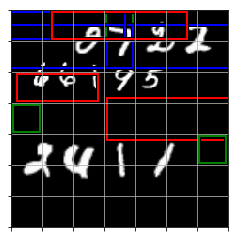

In [28]:
plot_anchors(anchors.numpy(), sample[0])

### Definindo modelo

In [29]:
def flatten_conv(x, k):
    """Converts a feature map to shape (batch_size, box_features, N_boxes).
    k is the number of anchor boxes per feature map cell.
    e.g. if used for bbox offsets, output would be (batch_size, 4, N_boxes).
    For class scores, output would be (batch_size, num_classes, N_boxes). """
    nb, nf, gx, gy = x.size()
    x = x.permute(0, 2, 3, 1).contiguous()
    return x.view(nb, -1, nf//k)


class OutConv(nn.Module):
    
    def __init__(self, in_channels, num_classes, k=1):
        super().__init__()
        self.k = k
        self.out_conv1 = nn.Conv2d(in_channels=in_channels, out_channels=4*k, kernel_size=3, padding=1)
        self.out_conv2 = nn.Conv2d(in_channels=in_channels, out_channels=(num_classes+1)*k, kernel_size=3,
                                   padding=1)
        # Seta o bias negativo para forçar a predição inicial de background (reduzir o custo
        # associado a centenas de boxes erradas no começo do treinamento)
        self.out_conv2.bias.data.fill_(-4)
        
    def forward(self, x):
        # Returns a list with bboxes coordinates offsets and predicted class scores
        return [flatten_conv(self.out_conv1(x), k=self.k),
                flatten_conv(self.out_conv2(x), k=self.k)]


class MyModel(nn.Module):
    
    def make_conv_block(self, in_channels, out_channels, kernel_size=3, padding=1, p=None):
        layers = [
            nn.Conv2d(in_channels=in_channels,
                      out_channels=out_channels,
                      kernel_size=kernel_size,
                      padding=padding,
                      bias=False,
                     ),
            nn.LeakyReLU(),
            nn.BatchNorm2d(out_channels),
        ]
        if p is not None:
            layers.append(nn.Dropout2d(p))

        return nn.Sequential(*layers)


    def __init__(self, num_classes, k):
        super(MyModel, self).__init__()
        
        self.num_classes = num_classes
        self.k = k
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        p = 0.
        
        # Contracting branch: max pooling every 2 convs
#         self.conv1 = self.make_conv_block(in_channels=1, out_channels=10, kernel_size=3, p=p)
#         self.conv2 = self.make_conv_block(in_channels=10, out_channels=10, kernel_size=1, padding=0, p=p)
        
#         self.conv3 = self.make_conv_block(in_channels=10, out_channels=20, kernel_size=3, p=p)
#         self.conv4 = self.make_conv_block(in_channels=20, out_channels=20, kernel_size=1, padding=0, p=p)
        
#         self.conv5 = self.make_conv_block(in_channels=20, out_channels=40, kernel_size=3, p=p)
#         self.conv6 = self.make_conv_block(in_channels=40, out_channels=40, kernel_size=1, padding=0, p=p)
        
#         self.conv7 = self.make_conv_block(in_channels=40, out_channels=80, kernel_size=3, p=p)
#         self.conv8 = self.make_conv_block(in_channels=80, out_channels=80, kernel_size=1, padding=0, p=p)
        
#         self.conv9 = self.make_conv_block(in_channels=80, out_channels=160, kernel_size=3, p=p)
#         self.conv10 = self.make_conv_block(in_channels=160, out_channels=160, kernel_size=1, padding=0, p=p)
        
#         self.conv11 = self.make_conv_block(in_channels=160, out_channels=320, kernel_size=3, p=p)
#         self.conv12 = self.make_conv_block(in_channels=320, out_channels=320, kernel_size=1, padding=0, p=p)
        self.conv1 = self.make_conv_block(in_channels=1, out_channels=32, kernel_size=3, p=p)
        self.conv2 = self.make_conv_block(in_channels=32, out_channels=32, kernel_size=3, p=p)
        
        self.conv3 = self.make_conv_block(in_channels=32, out_channels=32, kernel_size=3, p=p)
        self.conv4 = self.make_conv_block(in_channels=32, out_channels=32, kernel_size=3, p=p)
        
        self.conv5 = self.make_conv_block(in_channels=32, out_channels=32, kernel_size=3, p=p)
        self.conv6 = self.make_conv_block(in_channels=32, out_channels=32, kernel_size=3, p=p)
        
        self.conv7 = self.make_conv_block(in_channels=32, out_channels=32, kernel_size=3, p=p)
        self.conv8 = self.make_conv_block(in_channels=32, out_channels=32, kernel_size=3, p=p)
        
        self.conv9 = self.make_conv_block(in_channels=32, out_channels=32, kernel_size=3, p=p)
        self.conv10 = self.make_conv_block(in_channels=32, out_channels=32, kernel_size=3, p=p)
        
        self.conv11 = self.make_conv_block(in_channels=32, out_channels=64, kernel_size=3, p=p)
        self.conv12 = self.make_conv_block(in_channels=64, out_channels=64, kernel_size=3, p=p)
        
        self.conv13 = self.make_conv_block(in_channels=64, out_channels=64, kernel_size=3, p=p)
        self.conv14 = self.make_conv_block(in_channels=64, out_channels=64, kernel_size=3, p=p)
        
        # Prediction layers
        # out_channels= (4 + (num_classes+1)) * k:
        # For each anchor:
        #    2 channels for object and non-object probability scores)
        #    2 channels for box center x and y offsets
        #    10 channels for prob scores of the 10 classes
        self.out_conv1 = OutConv(in_channels=64, num_classes=num_classes, k=k)
        self.out_conv2 = OutConv(in_channels=64, num_classes=num_classes, k=k)
        
        # Construct Anchors and register as buffers
        
        anchors = torch.cat(
            (make_anchors(7, (28/224, 28/224)),
             make_anchors(7, (3*28/224, 28/224)),
             make_anchors(7, (5*28/224, 28/224)),
             make_anchors(3, (56/224, 56/224)),
             make_anchors(3, (2*44/224, 44/224)),
             make_anchors(3, (4*44/224, 44/224)),
        ), dim=0)
        anchors_cnr = hw2corners(anchors[:, :2], anchors[:, 2:])
        grid_sizes = torch.cat((
            torch.tensor([1/7]).repeat((7*7 * 3, 1)),
            torch.tensor([1/3]).repeat((3*3 * 3, 1))
        ), dim=0)
        
        self.register_buffer('anchors', anchors)
        self.register_buffer('anchors_cnr', anchors_cnr)
        self.register_buffer('grid_sizes', grid_sizes)
  
        
    def forward(self, x):
        
        # print(x.shape)
        x = self.conv1(x)
        x = self.conv2(x)
        # print(x.shape)
        x = self.max_pool(x)
        # print(x.shape)
        x = self.conv3(x)
        x = self.conv4(x)
        #print(x.shape)
        x = self.max_pool(x)
        #print(x.shape)
        x = self.conv5(x)
        x = self.conv6(x)
        #print(x.shape)
        x = self.max_pool(x)
        #print(x.shape)
        x = self.conv7(x)
        x = self.conv8(x)
        # print(x.shape)
        x = self.max_pool(x)
        #print(x.shape)
        x = self.conv9(x)
        #print(x.shape)
        x = self.conv10(x)
        #print(x.shape)
        x = self.max_pool(x)
        #print(x.shape)
        x = self.conv11(x)
        fm1 = self.conv12(x)
        #print(x.shape)
        x = self.max_pool(fm1)
        #print(x.shape)
        x = self.conv13(x)
        x = self.conv14(x)

        y1 = self.out_conv1(nn.functional.dropout2d(fm1, p=0.2))
        # print(y1.shape)
        y2 = self.out_conv2(nn.functional.dropout2d(x, p=0.2))
        # print(y2.shape)
        
        # output: boxes coordinates offsets and boxes class scores
        return [torch.cat([y1[0], y2[0]], dim=1),
                torch.cat([y1[1], y2[1]], dim=1)]

In [30]:
model = MyModel(num_classes=1, k=3)

### Testando o shape de saída

In [31]:
x = torch.randn((15, 1, 224, 224))
y1, y2 = model(x)
print('Boxes coordinates:', y1.shape)
print('Boxes class scores:', y2.shape)

Boxes coordinates: torch.Size([15, 174, 4])
Boxes class scores: torch.Size([15, 174, 2])


In [32]:
model.anchors

tensor([[0.0714, 0.0714, 0.1250, 0.1250],
        [0.0714, 0.2143, 0.1250, 0.1250],
        [0.0714, 0.3571, 0.1250, 0.1250],
        [0.0714, 0.5000, 0.1250, 0.1250],
        [0.0714, 0.6429, 0.1250, 0.1250],
        [0.0714, 0.7857, 0.1250, 0.1250],
        [0.0714, 0.9286, 0.1250, 0.1250],
        [0.2143, 0.0714, 0.1250, 0.1250],
        [0.2143, 0.2143, 0.1250, 0.1250],
        [0.2143, 0.3571, 0.1250, 0.1250],
        [0.2143, 0.5000, 0.1250, 0.1250],
        [0.2143, 0.6429, 0.1250, 0.1250],
        [0.2143, 0.7857, 0.1250, 0.1250],
        [0.2143, 0.9286, 0.1250, 0.1250],
        [0.3571, 0.0714, 0.1250, 0.1250],
        [0.3571, 0.2143, 0.1250, 0.1250],
        [0.3571, 0.3571, 0.1250, 0.1250],
        [0.3571, 0.5000, 0.1250, 0.1250],
        [0.3571, 0.6429, 0.1250, 0.1250],
        [0.3571, 0.7857, 0.1250, 0.1250],
        [0.3571, 0.9286, 0.1250, 0.1250],
        [0.5000, 0.0714, 0.1250, 0.1250],
        [0.5000, 0.2143, 0.1250, 0.1250],
        [0.5000, 0.3571, 0.1250, 0

In [33]:
model.anchors_cnr

tensor([[ 0.0089,  0.0089,  0.1339,  0.1339],
        [ 0.0089,  0.1518,  0.1339,  0.2768],
        [ 0.0089,  0.2946,  0.1339,  0.4196],
        [ 0.0089,  0.4375,  0.1339,  0.5625],
        [ 0.0089,  0.5804,  0.1339,  0.7054],
        [ 0.0089,  0.7232,  0.1339,  0.8482],
        [ 0.0089,  0.8661,  0.1339,  0.9911],
        [ 0.1518,  0.0089,  0.2768,  0.1339],
        [ 0.1518,  0.1518,  0.2768,  0.2768],
        [ 0.1518,  0.2946,  0.2768,  0.4196],
        [ 0.1518,  0.4375,  0.2768,  0.5625],
        [ 0.1518,  0.5804,  0.2768,  0.7054],
        [ 0.1518,  0.7232,  0.2768,  0.8482],
        [ 0.1518,  0.8661,  0.2768,  0.9911],
        [ 0.2946,  0.0089,  0.4196,  0.1339],
        [ 0.2946,  0.1518,  0.4196,  0.2768],
        [ 0.2946,  0.2946,  0.4196,  0.4196],
        [ 0.2946,  0.4375,  0.4196,  0.5625],
        [ 0.2946,  0.5804,  0.4196,  0.7054],
        [ 0.2946,  0.7232,  0.4196,  0.8482],
        [ 0.2946,  0.8661,  0.4196,  0.9911],
        [ 0.4375,  0.0089,  0.5625

In [34]:
model.anchors.shape

torch.Size([174, 4])

## Datasets e DataLoaders

In [35]:
ds = {
    'train': MultiSequenceDataset(datasets_mnist['train'],
                                  image_size=(224, 224),
                                  length=4096,
                                  transform=torchvision.transforms.ToTensor(),
                                  random=True),
    'val': MultiSequenceDataset(datasets_mnist['val'],
                                image_size=(224, 224),
                                length=1024,
                                transform=torchvision.transforms.ToTensor(),
                                random=False),
}

def collate_fn(batch):
    """Separates a list of (img, dict('coords', 'label')) into a batch."""
    imgs = torch.stack(tuple(sample[0] for sample in batch), dim=0)
    coords = [
        torch.from_numpy(np.stack([box['coords'] for box in sample[1]], axis=0)).float() for sample in batch
    ]
    # Override labels to output always 0 (presence of digits)
    # labels = [torch.tensor([box['label'] for box in sample[1]]) for sample in batch]
    labels = [torch.tensor([0 for box in sample[1]]) for sample in batch]
    return imgs, (coords, labels)

In [36]:
bs = 64
dls = {
    'train': data.DataLoader(ds['train'],
                             batch_size=bs,
                             num_workers=os.cpu_count(),  # put 0 here to debug
                             shuffle=True,
                             collate_fn=collate_fn),
    'val': data.DataLoader(ds['val'],
                           batch_size=bs,
                           num_workers=os.cpu_count(),
                           shuffle=False,
                           collate_fn=collate_fn),
}

In [37]:
def get_batch(dl):
    n_workers = dl.num_workers
    dl.num_workers = 0
    X, Y = next(iter(dl))
    dl.num_workers = n_workers
    return X, Y

In [38]:
X, Y = get_batch(dls['train'])

print(X.shape, X.type(), X.min(), X.max())

print('Boxes:', len(Y[0]), len(Y[0][0]), len(Y[0][0][0]))
print(Y[0][0], Y[0][0].dtype)
print('Labels shape:', len(Y[1]), len(Y[1][0]))
print(Y[1][0], Y[1][0].dtype)

torch.Size([64, 1, 224, 224]) torch.FloatTensor tensor(0.) tensor(1.)
Boxes: 64 3 4
tensor([[0.1473, 0.6786, 0.8080, 0.8214],
        [0.1205, 0.3884, 0.7991, 0.5714],
        [0.6384, 0.0223, 0.8661, 0.2500]]) torch.float32
Labels shape: 64 3
tensor([0, 0, 0]) torch.int64


In [39]:
X, Y = get_batch(dls['val'])

print(X.shape, X.type(), X.min(), X.max())

print('Boxes "shape":', len(Y[0]), len(Y[0][0]), len(Y[0][0][0]))
print(Y[0][0], Y[0][0].dtype)
print('Labels "shape":', len(Y[1]), len(Y[1][0]))
print(Y[1][0], Y[1][0].dtype)

torch.Size([64, 1, 224, 224]) torch.FloatTensor tensor(0.) tensor(1.)
Boxes "shape": 64 3 4
tensor([[0.4598, 0.0402, 0.6607, 0.2411],
        [0.3036, 0.2902, 0.7188, 0.5089],
        [0.1696, 0.5938, 0.9777, 0.8125]]) torch.float32
Labels "shape": 64 3
tensor([0, 0, 0]) torch.int64


In [40]:
model = model.to('cuda')
X = to_device(X, 'cuda')
Y = to_device(Y, 'cuda')
for b_box, b_cls, box, cls in zip(*model(X), *Y):
    print(b_box.shape)
    print(b_cls.shape)
    print(box.shape)
    print(cls.shape)
    break

torch.Size([174, 4])
torch.Size([174, 2])
torch.Size([3, 4])
torch.Size([3])


## Loss customizada e Trainer

Funções transcritas do notebook pascal-multi do fast.ai.

In [41]:
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, pred, targ):
        t = one_hot_embedding(targ, self.num_classes+1).to(pred.device)
        ## t = V(t[:,:-1].contiguous())#.cpu()    # Linha do fast.ai. Abaixo está a equivalente
        t = t[:,:-1].contiguous().requires_grad_(False)
        x = pred[:,:-1]
        w = self.get_weight(x,t)
        return F.binary_cross_entropy_with_logits(x, t, w, reduction='sum')/self.num_classes
    
        # Comentado abaixo: alteração para incluir explicitamente a classe de background no modelo
        # x = pred
        # w = self.get_weight(pred, t)
        # pos_weight = torch.tensor([1.]*10 + [0.1], requires_grad=False).to(pred.device)
        # pos_weight = None
        # return F.binary_cross_entropy_with_logits(x, t, w, pos_weight=pos_weight)
    
    def get_weight(self,x,t):
        return None
    

class FocalLoss(BCE_Loss):
    def get_weight(self,x,t):
        alpha, gamma = 0.25, 1
        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = alpha*t + (1-alpha)*(1-t)
        return w * (1-pt).pow(gamma)

num_classes = 1
# loss_f = BCE_Loss(num_classes)
loss_f = FocalLoss(num_classes)

### Funções para cálculo do IoU

In [42]:
def intersect(box_a, box_b):
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_sz(b):
    return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))

def jaccard(box_a, box_b):
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union

##### Exemplos de IoU para dígitos únicos

Testando IoU entre boxes 28x28 (menor dígito) e 37x37

In [43]:
# IoU de feature map com anchor 37x37 e dígito 28x28
box_a = torch.tensor([[0., 0., 37., 37.]])
box_b = torch.tensor([[0., 0., 28., 28.]])
jaccard(box_a, box_b)

tensor([[0.5727]])

In [44]:
# IoU de feature map com anchor 37x37 e dígito 56x56
box_a = torch.tensor([[0., 0., 37., 37.]])
box_b = torch.tensor([[0., 0., 56., 56.]])
jaccard(box_a, box_b)

tensor([[0.4365]])

In [45]:
# IoU de feature map com anchor 46x46 e dígito 28x28
box_a = torch.tensor([[0., 0., 46., 46.]])
box_b = torch.tensor([[0., 0., 28., 28.]])
jaccard(box_a, box_b)

tensor([[0.3705]])

In [46]:
# IoU de feature map com anchor 46x46 e dígito 56x56
box_a = torch.tensor([[0., 0., 46., 46.]])
box_b = torch.tensor([[0., 0., 56., 56.]])
jaccard(box_a, box_b)

tensor([[0.6747]])

### Funções para treinamento

In [47]:

def actn_to_bb(actn, anchors):
    """
    Uses activation to modify the anchors (shift the centers around
    the grid cell center and resize the dimensions.
    Returns the final predicted boxes in the format (x0,y0,x1,y1).
    """
    actn_bbs = torch.tanh(actn)
    # Desloca centros das anchors dentro das células do grid
    actn_centers = (actn_bbs[:,:2]/2 * model.grid_sizes) + anchors[:,:2]
    # Permite alterar largura/altura da anchor por um fator [0.5, 1.5]
    actn_hw = (actn_bbs[:,2:]/2 + 1) * anchors[:,2:]
    return hw2corners(actn_centers, actn_hw)

def map_to_ground_truth(overlaps, print_it=False):
    prior_overlap, prior_idx = overlaps.max(1)
    if print_it: print(prior_overlap)
    # import pdb; pdb.set_trace()
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx):
        gt_idx[o] = i
    return gt_overlap, gt_idx


def negative_mining(neg_idx, num_boxes):
    # Select `num_boxes` randomly from neg_idx boxes.
    select_idx = np.arange(len(neg_idx))
    np.random.shuffle(select_idx)
    select_idx = select_idx[:num_boxes]
    select_idx = torch.from_numpy(select_idx).long().to(neg_idx.device)
    neg_idx = neg_idx[select_idx]
    return neg_idx

def hard_negative_mining(neg_idx, neg_cls_scores, final_num):
    # Sorts negative boxes by background class score and picks
    # the boxes with lower scores (higher error)
    selected_idx = torch.sort(neg_cls_scores[:, -1])[1][:final_num]
    return neg_idx[selected_idx]
    
def ssd_1_loss(b_c, b_bb, bbox, clas, print_it=False):
    # bbox, clas = get_y(bbox, clas)
    # Obtem as boxes preditas pelo modelo
    a_ic = actn_to_bb(b_bb, model.anchors)
    # Calcula o IoU entre os targets (bbox) e as âncoras
    overlaps = jaccard(bbox.data, model.anchors_cnr.data)
    # Realiza o match entre as ancoras e as boxes GT pelo IoU
    gt_overlap, gt_idx = map_to_ground_truth(overlaps, print_it)
    # Constrói os tensores target (gt_clas e gt_bbox)
    # gt_clas deve possuir um índice de classe para cada bbox predita
    # gt_bbox deve possuir 4 parâmetros para cada bbox predito
    # Associa as classes corretas para as boxes que foram match
    gt_clas = clas[gt_idx]
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:,0]
    # Seta classe background (classe 10) para anchors sem match
    gt_clas[1-pos] = num_classes
    # Constroi gt_bbox usando, para cada anchor, a bbox GT com maior overlap.
    gt_bbox = bbox[gt_idx]
    # Localization loss: L1 Loss diretamente nas coordenadas das bboxes (x0,y0,x1,y1)
    # Considera apenas as boxes que foram match
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    # Class loss:
    # Hard negative mining
    neg_idx = torch.nonzero(1-pos)[:,0]
    # import pdb; pdb.set_trace()
    # neg_idx = hard_negative_mining(neg_idx, b_c[neg_idx], 3*len(pos_idx))
    select_idx = torch.cat([pos_idx, neg_idx])
    clas_loss  = loss_f(b_c[select_idx], gt_clas[select_idx])
    
    return loc_loss, clas_loss

def ssd_loss(pred, targ, print_it=False):
    lcs, lls = 0., 0.
    # Itera nas imagens do batch
    for b_box, b_cls, bbox, clas in zip(*pred, *targ):
        loc_loss, clas_loss = ssd_1_loss(b_cls, b_box, bbox, clas, print_it)
        lls += loc_loss
        lcs += clas_loss
    if print_it: print(f'loc: {lls.item()}, clas: {lcs.item()}')
    return 5*lls + lcs

### Testando cálculo do IoU das ânchoras para uma amostra

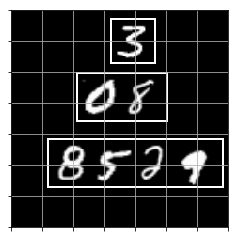

In [48]:
ax = show_img(X[0].cpu().numpy().squeeze(0))
boxes = Y[0][0]
boxes = corners2xyhw(boxes[:, :2], boxes[:, 2:])
for box in boxes:
    draw_rect(ax, box.cpu().numpy()*224)

In [49]:
classes = Y[1][0]
classes

tensor([0, 0, 0], device='cuda:0')

In [50]:
boxes = Y[0][0]
# boxes x0, y0, x1, y1
boxes

tensor([[0.4598, 0.0402, 0.6607, 0.2411],
        [0.3036, 0.2902, 0.7188, 0.5089],
        [0.1696, 0.5938, 0.9777, 0.8125]], device='cuda:0')

In [51]:
Y[1]

[tensor([0, 0, 0], device='cuda:0'),
 tensor([0, 0, 0], device='cuda:0'),
 tensor([0, 0, 0], device='cuda:0'),
 tensor([0, 0, 0, 0], device='cuda:0'),
 tensor([0, 0, 0, 0, 0], device='cuda:0'),
 tensor([0, 0, 0, 0], device='cuda:0'),
 tensor([0, 0, 0, 0], device='cuda:0'),
 tensor([0, 0, 0], device='cuda:0'),
 tensor([0, 0, 0], device='cuda:0'),
 tensor([0, 0, 0, 0], device='cuda:0'),
 tensor([0, 0, 0], device='cuda:0'),
 tensor([0, 0, 0, 0], device='cuda:0'),
 tensor([0, 0, 0, 0], device='cuda:0'),
 tensor([0, 0, 0, 0], device='cuda:0'),
 tensor([0, 0, 0], device='cuda:0'),
 tensor([0, 0, 0], device='cuda:0'),
 tensor([0, 0, 0, 0], device='cuda:0'),
 tensor([0, 0, 0, 0], device='cuda:0'),
 tensor([0, 0, 0, 0, 0], device='cuda:0'),
 tensor([0, 0, 0, 0], device='cuda:0'),
 tensor([0, 0, 0, 0, 0], device='cuda:0'),
 tensor([0, 0, 0, 0], device='cuda:0'),
 tensor([0, 0, 0], device='cuda:0'),
 tensor([0, 0, 0, 0], device='cuda:0'),
 tensor([0, 0, 0], device='cuda:0'),
 tensor([0, 0, 0], de

In [52]:
targ = Y[0][0]
jaccard(targ, model.anchors_cnr).shape

torch.Size([3, 174])

In [53]:
# Cálculo do match de cada bbox GT (IoU + índice da anchor com maior IoU)
torch.max(jaccard(targ.data, model.anchors_cnr), dim=1)

(tensor([0.4711, 0.5161, 0.3768], device='cuda:0'),
 tensor([150,  72, 130], device='cuda:0'))

In [54]:
# Cálculo dos matches secundários:
# Deve calcular o maior IoU entre cada anchor box e as boxes GT.
# Se alguma ultrapassar o limiar (e não tiver sido match na etapa acima),
# é match também (mais de uma anchor para uma mesma box GT)
torch.max(jaccard(targ, model.anchors_cnr), dim=0)

(tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0663, 0.0523, 0.0000, 0.0000, 0.0000, 0.1578, 0.0845,
         0.0782, 0.0616, 0.0000, 0.2077, 0.1958, 0.1720, 0.0916, 0.0782, 0.0616,
         0.0000, 0.1555, 0.1470, 0.1720, 0.0916, 0.0782, 0.0616, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0782, 0.0616, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0692, 0.0546, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0466,
         0.0370, 0.0000, 0.0000, 0.0000, 0.0979, 0.0537, 0.1310, 0.1022, 0.0000,
         0.1003, 0.0951, 0.2802, 0.1429, 0.2302, 0.1761, 0.0000, 0.2753, 0.2588,
         0.5161, 0.2415, 0.2302, 0.1761, 0.0000, 0.2753, 0.2588, 0.3142, 0.1583,
         0.2302, 0.1761, 0.0000, 0.0720, 0.0683, 0.1229, 0.0667, 0.2302, 0.1761,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1339, 0.1043, 0.0000, 0.0000,
         0.0000, 0.0632, 0.0352, 0.1035, 0.0812, 0.0000, 0.0560, 0.0531, 0.1978,
         0.1042, 0.1854, 0.1

In [55]:
# Função que realiza as 2 etapas acima.
# Os matches "primários" ficam com IoU de 1.99 para garantir match
gt_overlap, gt_idx = map_to_ground_truth(jaccard(targ.data, model.anchors_cnr), print_it=True)
gt_overlap, gt_idx

tensor([0.4711, 0.5161, 0.3768], device='cuda:0')


(tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0663, 0.0523, 0.0000, 0.0000, 0.0000, 0.1578, 0.0845,
         0.0782, 0.0616, 0.0000, 0.2077, 0.1958, 0.1720, 0.0916, 0.0782, 0.0616,
         0.0000, 0.1555, 0.1470, 0.1720, 0.0916, 0.0782, 0.0616, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0782, 0.0616, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0692, 0.0546, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0466,
         0.0370, 0.0000, 0.0000, 0.0000, 0.0979, 0.0537, 0.1310, 0.1022, 0.0000,
         0.1003, 0.0951, 0.2802, 0.1429, 0.2302, 0.1761, 0.0000, 0.2753, 0.2588,
         1.9900, 0.2415, 0.2302, 0.1761, 0.0000, 0.2753, 0.2588, 0.3142, 0.1583,
         0.2302, 0.1761, 0.0000, 0.0720, 0.0683, 0.1229, 0.0667, 0.2302, 0.1761,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1339, 0.1043, 0.0000, 0.0000,
         0.0000, 0.0632, 0.0352, 0.1035, 0.0812, 0.0000, 0.0560, 0.0531, 0.1978,
         0.1042, 0.1854, 0.1

In [56]:
for i, (gt_ov, gt_ix) in enumerate(zip(gt_overlap, gt_idx)):
    if gt_ov > 0.5:
        is_primary_match = gt_ov == 1.99
        print(f'Anchor {i}: match com GT box {gt_ix.item()} | IoU {gt_ov.item():.4f}', end='')
        print(' (match primário)' if is_primary_match else '')

Anchor 72: match com GT box 1 | IoU 1.9900 (match primário)
Anchor 130: match com GT box 2 | IoU 1.9900 (match primário)
Anchor 150: match com GT box 0 | IoU 1.9900 (match primário)


In [57]:
pred = model(X[:2])
ssd_loss((pred[0], pred[1]), (Y[0], Y[1]), print_it=True)

tensor([0.4711, 0.5161, 0.3768], device='cuda:0')
tensor([0.4093, 0.4014, 0.4872], device='cuda:0')
loc: 0.13220803439617157, clas: 12.177074432373047


tensor(12.8381, device='cuda:0', grad_fn=<ThAddBackward>)

O erro de classe é muito superior ao de localização inicialmente, mas cai rapidamente por conta da Focal Loss.

## Treinamento

In [58]:
class IoUMetric(ptt.Callback):
    def __init__(self):
        super().__init__()
        self.name1 = 'recall_iou_0.5'
        self.name2 = 'recall_iou_0.2'

    def on_batch_end(self, epoch_num, batch_num, x, y_true, y_pred, loss):
        pass

    def on_vbatch_end(self, epoch_num, batch_num, x, y_true, y_pred, loss):
        batch_box, batch_cls = y_pred
        #import pdb; pdb.set_trace()

        for box, cls, gt_box, gt_cls in zip(batch_box, batch_cls, y_true[0], y_true[1]):
            box = actn_to_bb(box, self.trainer.model.anchors)
            # idx_obj: foregound boxes
            # cls_pred = cls.max(1)[1]
            # idx_obj = (cls_pred != num_classes).nonzero()
            # Boxes com objecto: probabilidade > threshold
            idx_obj = (cls.sigmoid()[:, 0] > 0.5).nonzero()
            if len(idx_obj):
                idx_obj = idx_obj[:, 0]
                box = box[idx_obj]
                iou = jaccard(box, gt_box)   # out: (n_obj_boxes, n_gt)
                iou_max = iou.max(0)[0]
                self.valid_accum_1 += (iou_max > 0.5).sum().item()
                self.valid_accum_2 += (iou_max > 0.2).sum().item()
            self.n_valid_samples += len(gt_box)

    def on_epoch_begin(self, epoch_num, metrics):
        self.valid_accum_1 = 0
        self.valid_accum_2 = 0
        self.n_valid_samples = 0

    def on_epoch_end(self, epoch_num, metrics):
        if self.n_valid_samples > 0:
            metrics['valid'][self.name1].append(1.0 * self.valid_accum_1 / self.n_valid_samples)
            metrics['valid'][self.name2].append(1.0 * self.valid_accum_2 / self.n_valid_samples)

    def on_train_begin(self, n_epochs, metrics):
        metrics['valid'][self.name1] = []
        metrics['valid'][self.name2] = []

### Trainer

In [59]:
class MyTrainer(ptt.DeepNetTrainer):
    
    # init alterado para criar o optimizer após o método .to() no modelo
    def __init__(self, model, lr, devname='cpu', callbacks=[], **kwargs):
        self.dev_name = devname
        device = torch.device(self.dev_name)
        self.last_epoch = 0
        
        assert (model is not None)
        self.model = model.to(device)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr, weight_decay=5e-3)
        self.criterion = ssd_loss
        
#         def lr_schedule(epoch):
#             if epoch <= 10:
#                 return 0.1
#             elif 10 < epoch <= 30:
#                 return 1
#             elif 30 < epoch <= 50:
#                 return 0.1
#             elif epoch >= 60:
#                 return 0.01
#             return 1.
#         self.scheduler = torch.optim.lr_scheduler.LambdaLR(self.optimizer, lr_schedule)
        # SGDR: Scheduler that must be used as a callback
        self.scheduler = None
        To = kwargs.get('To', 1)
        Tmul = kwargs.get('Tmul', 2)
        sgdr = ptt.SGDRestarts(self.optimizer,
                               self.last_epoch if self.last_epoch != 0 else -1,
                               eta_min=1e-8,
                               To=To,
                               Tmul=Tmul,
                               verbose=False)
        callbacks.insert(0, sgdr)
        
        self.metrics = dict(train=OrderedDict(losses=[]), valid=OrderedDict(losses=[]))
        
        self.callbacks = []
        if callbacks is not None:
            for cb in callbacks:
                self.callbacks.append(cb)
                cb.trainer = self

In [60]:
model = MyModel(num_classes, k=3)

In [61]:
cb_chkpt = ptt.ModelCheckpoint('.models/ssd_fastai_sequence_32_64', reset=True, verbose=1, load_best=False)

trainer = MyTrainer(model,
                    lr=0.0003,
                    devname=0,
                    callbacks = [
                        IoUMetric(),
                        ptt.PrintCallback(),
                        cb_chkpt,
                    ],
                    To=2,
                    Tmul=2,
                   )

In [ ]:
n_epochs = 120
trainer.fit_loader(n_epochs, dls['train'], dls['val'])

Start training for 120 epochs
  1 (LRs: [0.0003]):  34.7s   T: 8.82357 *   V: 9.09303 *  0.00000 *  0.00000 *  
  2 (LRs: [1e-08]):  34.7s   T: 6.47861 *   V: 5.73145 *  0.08759    0.12655    
  3 (LRs: [0.00025704295511099075]):  35.0s   T: 5.05235 *   V: 5.25418 *  0.13540    0.15778    
  4 (LRs: [0.00015092896119598762]):  35.2s   T: 4.51252 *   V: 4.87292 *  0.20088    0.23460    
  5 (LRs: [4.426969259181247e-05]):  35.2s   T: 4.26435 *   V: 4.80834 *  0.20503    0.24399    
  6 (LRs: [1e-08]):  35.1s   T: 4.20659 *   V: 4.65793 *  0.21663    0.26941    
  7 (LRs: [0.0002888890869551915]):  35.0s   T: 3.78323 *   V: 4.46778 *  0.27604    0.33020    
  8 (LRs: [0.00025655540102480207]):  35.2s   T: 3.39011 *   V: 4.35586 *  0.32412    0.38602    
  9 (LRs: [0.00020793765370754228]):  35.2s   T: 3.05811 *   V: 4.33474 *  0.32136    0.37193    
 10 (LRs: [0.0001504660787162005]):  35.2s   T: 2.77099 *   V: 4.27760 *  0.42415    0.51810    
 11 (LRs: [9.29240372221841e-05]):  35.2s  

In [106]:
cb_chkpt = ptt.ModelCheckpoint('.models/ssd_fastai_sequence_32_64', reset=False, verbose=1, load_best=True)

n_epochs = 0
trainer = MyTrainer(model,
                    lr=0.00003,
                    devname=0,
                    callbacks = [
                        IoUMetric(),
                        ptt.PrintCallback(),
                        cb_chkpt,
                    ],
                    To=2,
                    Tmul=2,
                   )
trainer.fit_loader(n_epochs, dls['train'], dls['val'])

Start training for 0 epochs
Model loaded from .models/ssd_fastai_sequence_32_64.model
Stop training at epoch: 13/13
Best model was saved at epoch 13 with loss 4.14037: .models/ssd_fastai_sequence_32_64
Model loaded from .models/ssd_fastai_sequence_32_64.model


In [553]:
trainer.load_state('.models/ssd_fastai_sequence')
model = trainer.model

### Visualizando algumas amostras

In [108]:
X, Y = get_batch(dls['train'])
X = X[:20]
Y = (Y[0][:20], Y[1][:20])
X = to_device(X, 'cuda')
Y = to_device(Y, 'cuda')

model = model.eval()
pred = model(X)
print('Loss: ', ssd_loss(pred, Y, print_it=True))
bbox_pred = torch.stack([
    torch.clamp(actn_to_bb(bb_pred, model.anchors), min=0, max=1) for bb_pred in pred[0]
], dim=0)
prob_pred = pred[1].sigmoid()
cls_pred = pred[1][:,:, :1].max(2)[1]
thresh = 0.5
has_obj = (prob_pred[:,:, :1] > thresh).nonzero()

print('')
print('bbox_pred.shape', bbox_pred.shape)
print('prob_pred.shape', prob_pred.shape)
print('cls_pred.shape', cls_pred.shape)

pred = to_device(pred, 'cpu')
bbox_pred = to_device(bbox_pred, 'cpu')
prob_pred = to_device(prob_pred, 'cpu')
cls_pred = to_device(cls_pred, 'cpu')

tensor([0.6005, 0.4461, 0.7044, 0.5957], device='cuda:0')
tensor([0.5871, 0.4426, 0.7040], device='cuda:0')
tensor([0.4928, 0.5545, 0.2940], device='cuda:0')
tensor([0.4000, 0.3106, 0.5618, 0.4026], device='cuda:0')
tensor([0.5234, 0.6947, 0.6204], device='cuda:0')
tensor([0.4051, 0.3943, 0.4733, 0.3544, 0.5209], device='cuda:0')
tensor([0.3822, 0.4056, 0.5395, 0.3941], device='cuda:0')
tensor([0.4675, 0.6336, 0.5967], device='cuda:0')
tensor([0.4830, 0.3980, 0.4694, 0.4712, 0.6117], device='cuda:0')
tensor([0.4144, 0.4042, 0.3722, 0.3912], device='cuda:0')
tensor([0.5429, 0.6257, 0.4238], device='cuda:0')
tensor([0.3973, 0.5555, 0.4969, 0.4505, 0.2846], device='cuda:0')
tensor([0.4490, 0.6901, 0.3364, 0.6094, 0.4701], device='cuda:0')
tensor([0.5688, 0.5644, 0.4124], device='cuda:0')
tensor([0.4283, 0.5946], device='cuda:0')
tensor([0.7765, 0.7266, 0.4805], device='cuda:0')
tensor([0.3410, 0.4042, 0.5405], device='cuda:0')
tensor([0.4756, 0.4779, 0.5625], device='cuda:0')
tensor([0.51

In [109]:
Y[1][0]

tensor([0, 0, 0, 0], device='cuda:0')

In [110]:
def show_sample(x, boxes, classes, probs=None, thresh=0.2, ax=None):
    ax = show_img(x, ax=ax)
    
    if probs is not None:
        idx = (probs > thresh).nonzero()
        idx = idx[:, 0] if len(idx) else torch.tensor([], dtype=torch.long)
    else:
        idx = torch.arange(len(boxes))
    for i, (b, c) in enumerate(zip(boxes[idx], classes[idx])):
        color = colr_list[i%12]
        box = torch.cat([b[:2], b[2:]-b[:2]]) * x.shape[-1]
        draw_rect(ax, box, color=color)
        draw_text(ax, box[:2], c.item(), color=color)
        

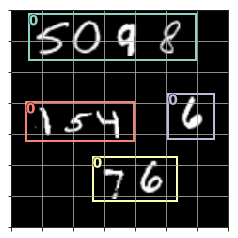

In [111]:
ix = 0
show_sample(X[ix].cpu().numpy().squeeze(), Y[0][ix], Y[1][ix])

In [112]:
((pred[1][ix].sigmoid()[:, 0]) > 0.5)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
        1, 1, 0, 0, 0, 0], dtype=torch.uint8)

In [113]:
pred[1][ix].max(1)[1]

tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
        0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 0, 1])

In [114]:
bbox_pred[ix]

tensor([[0.0000, 0.0175, 0.1284, 0.1343],
        [0.0164, 0.1519, 0.1410, 0.2749],
        [0.0252, 0.3031, 0.1340, 0.4276],
        [0.0000, 0.4395, 0.1368, 0.5523],
        [0.0000, 0.5950, 0.1077, 0.7023],
        [0.0172, 0.7472, 0.1211, 0.8551],
        [0.0086, 0.8583, 0.1431, 0.9637],
        [0.1469, 0.0219, 0.2854, 0.1375],
        [0.1357, 0.1752, 0.2654, 0.2860],
        [0.1715, 0.3101, 0.3152, 0.4199],
        [0.1254, 0.4580, 0.2731, 0.5596],
        [0.1708, 0.6252, 0.3112, 0.7087],
        [0.1481, 0.7431, 0.2987, 0.8306],
        [0.0976, 0.8700, 0.2554, 0.9687],
        [0.2806, 0.0318, 0.4061, 0.1354],
        [0.3197, 0.1639, 0.4511, 0.2792],
        [0.3137, 0.2848, 0.4337, 0.4164],
        [0.2831, 0.4596, 0.4091, 0.5977],
        [0.3088, 0.5734, 0.4339, 0.7223],
        [0.3241, 0.7044, 0.4330, 0.8470],
        [0.3170, 0.8641, 0.4332, 0.9907],
        [0.4385, 0.0203, 0.5861, 0.1448],
        [0.4562, 0.1479, 0.5649, 0.3064],
        [0.4836, 0.2945, 0.6220, 0

In [115]:
idx_obj = (prob_pred[ix][:, 0] > 0.5).nonzero()[:, 0]

boxes = bbox_pred[ix][idx_obj]
clss = cls_pred[ix][idx_obj]
probs = prob_pred[ix][idx_obj]

In [116]:
boxes.shape, clss.shape, probs.shape

(torch.Size([13, 4]), torch.Size([13]), torch.Size([13, 2]))

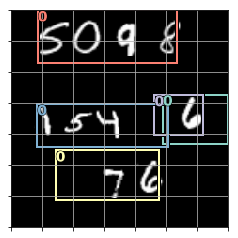

In [122]:
show_sample(X[ix].cpu().numpy().squeeze(), boxes, clss, probs=probs, thresh=0.8)

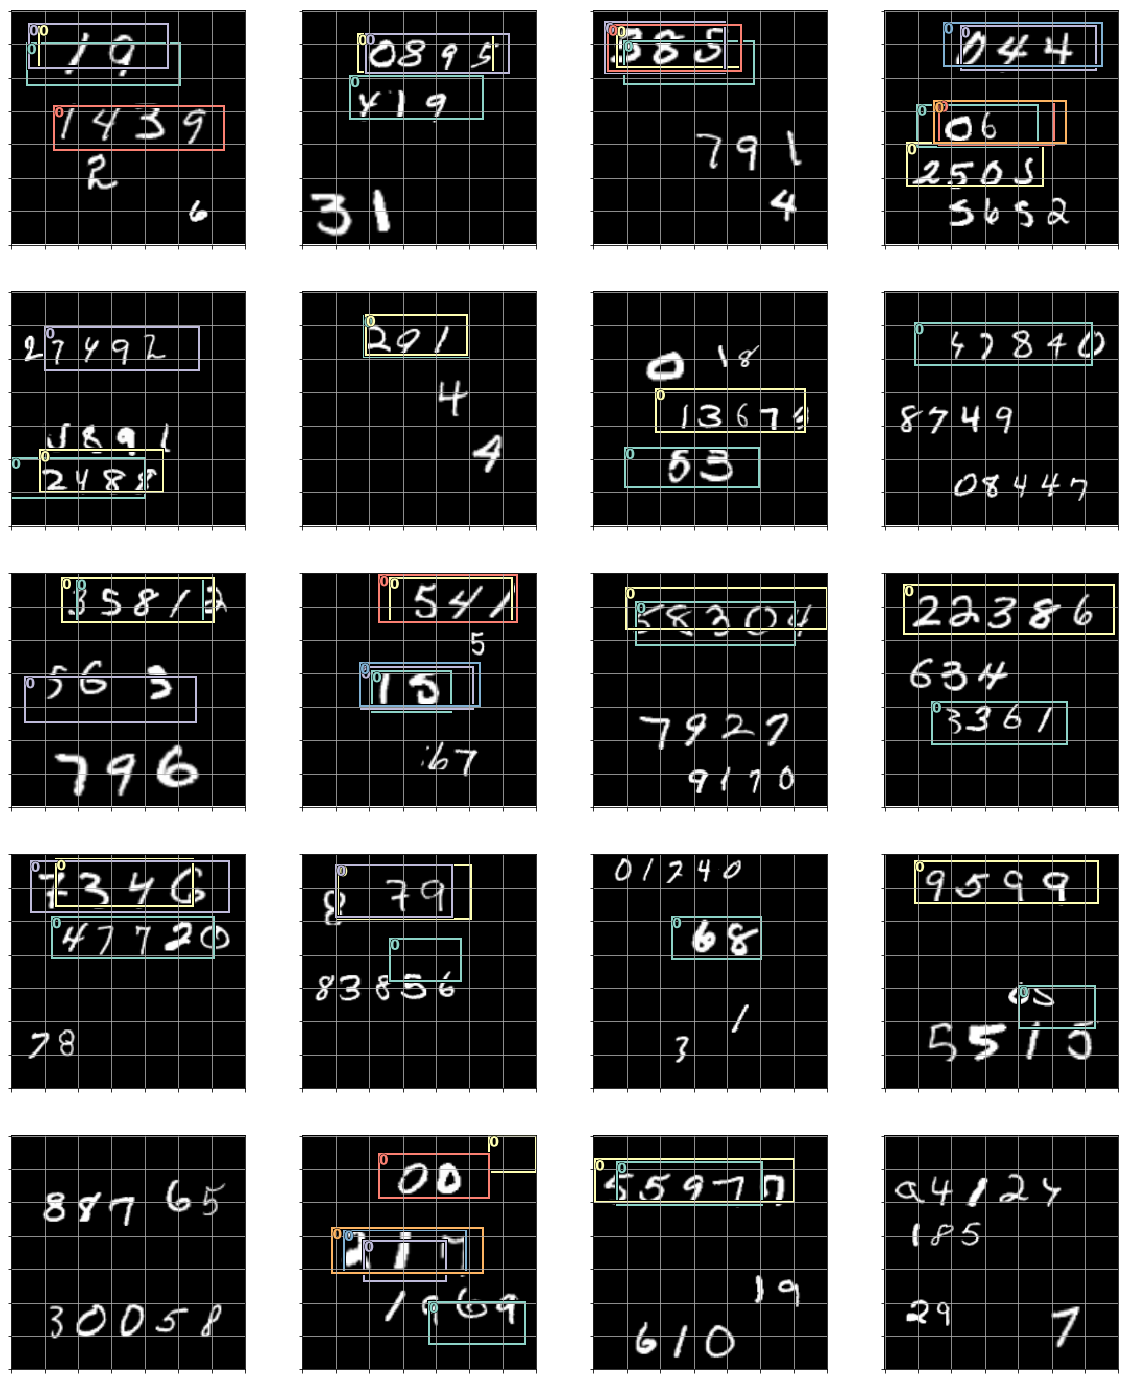

In [96]:
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(20, 25))
axs = np.ravel(axs)

for j, (x, boxes, clss, probs) in enumerate(zip(X, bbox_pred, cls_pred, prob_pred)):
    ax = axs[j]
    idx_obj = (prob_pred[ix][:, 0] > 0.5).nonzero()
    if len(idx_obj):
        idx_obj = idx_obj[:, 0]
        boxes = boxes[idx_obj]
        clss = clss[idx_obj]
        probs = probs[idx_obj]
    else:
        boxes, clss, probs = [], [], []
    show_sample(x.cpu().numpy().squeeze(), boxes, clss, probs, ax=ax, thresh=0.99)

## Avaliação


In [109]:
def to_cpu(T):
    if isinstance(T, (list, tuple)):
        return tuple(t.cpu() for t in T)
    elif isinstance(T, dict):
        return {k: t.cpu() for k, t in T.items()}
    return T.cpu()

def to_np(T):
    T = to_cpu(T)
    if isinstance(T, (list, tuple)):
        return tuple(t.numpy() for t in T)
    elif isinstance(T, dict):
        return {k: t.numpy() for k, t in T.items()}
    return T.numpy()

In [110]:
model = model.eval()

ds['eval'] =  MultiDigitDataset(datasets_mnist['val'],
                               length=12800,
                               transform=torchvision.transforms.ToTensor(),
                               random=True,
                               image_size=(200, 200))

dls['eval'] = data.DataLoader(ds['val'],
                              batch_size=128,
                              num_workers=os.cpu_count(),
                              shuffle=False,
                              collate_fn=collate_fn)


X, Y = get_batch(dls['eval'])

sample_no = 63
x = X[sample_no:sample_no+1, ...]
boxes, labels = Y['coords'][sample_no], Y['labels'][sample_no]

with torch.no_grad():
    y_pred = model(x.to(0))
y_pred = to_cpu(y_pred)

x = x.cpu()[0]

y_pred[0].shape, y_pred[1].shape

(torch.Size([1, 14, 20, 20]), torch.Size([1, 14, 10, 10]))

### Visualizando amostra de entrada

#### Non-Maximum Suppression

#### OBS: A implementação `non_max_suppression_fast` possuia um erro: as bboxes devem ser ordenadas pela maior probabilidade de presença de objeto, e não pela maior coordenada de y

In [223]:
# Funções de conversão de bounding boxes entre [x1, y1, h, w] e [x1, y1, x2, y2]
def hw2xy(boxes):
    out = np.zeros_like(boxes)
    out[:, :2] = boxes[:, :2]
    out[:, 2:] = boxes[:, :2] + boxes[:, 2:] + 1
    return out


def xy2hw(boxes):
    out = np.zeros_like(boxes)
    out[:, :2] = boxes[:, :2]
    out[:, 2:] = boxes[:, 2:] - boxes[:, :2] - 1
    return out


# Malisiewicz et al.
# Adaptado de: https://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
def non_max_suppression_fast(boxes, confs, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes	
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    # compute the area of the bounding boxes and sort the bounding
    # boxes by the highest confidences
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(confs)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))

    # Return only the indices of the boxes that survived
    return np.asarray(pick)

### Visualizando

In [126]:
X, Y = get_batch(dls['eval'])
with torch.no_grad():
    ypred = model(X.cuda())
ypred = to_cpu(ypred)

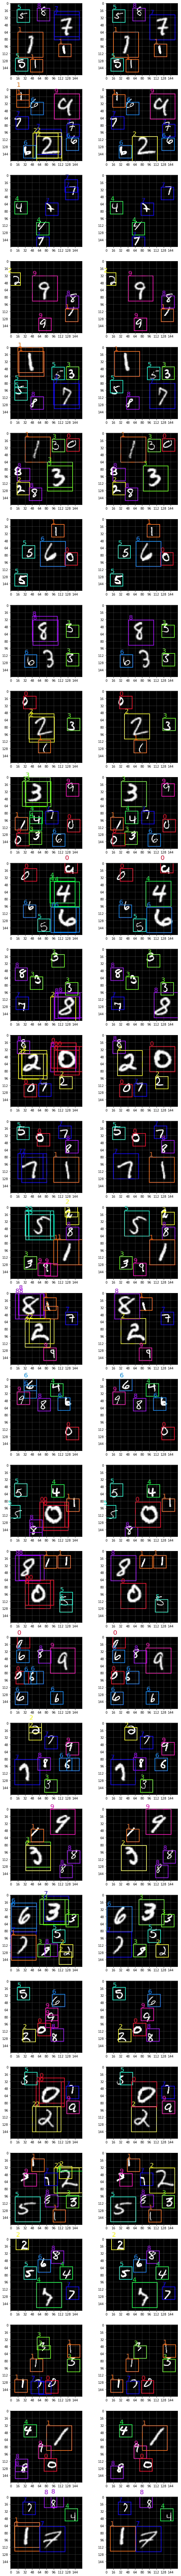

In [224]:
nrows = 30
ncols = 2
fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows))

for ix, row in enumerate(axs):
    
    boxes, labels, confs = model.decode_bboxes((ypred[0][ix], ypred[1][ix]), conf_thresh=0.2)
    # Plot without NMS
    ax = row[0]
    plot_output(X[ix].numpy().squeeze(), (boxes, labels, confs), ax=ax)
    
    # Plot after NMS
    idx = non_max_suppression_fast(hw2xy(boxes), confs, overlapThresh=0.1)
    boxes, labels, confs = boxes[idx], labels[idx], confs[idx]
    ax = row[1]
    plot_output(X[ix].numpy().squeeze(), (boxes, labels, confs), ax=ax)